In [2]:
import numpy as np
import pandas as pd
import os
import gif2numpy
import cv2
from PIL import Image
import tensorflow as tf 
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt 
import argparse
import glob

# the functions used to cut and preprocess the images

In [2]:
# get images
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return np.array(gray).astype('int')

np_frames, extensions, image_specifications = gif2numpy.convert("alphabet.gif")
img = np_frames[0]

for i in range(10):
	cv2.imwrite(chr(48 + (i+1)%10)+'.jpg', img[43*4:43*5+1, i*43:(i+1)*43+1, :])



In [3]:
filenames = glob.glob('*.jpg')
print(filenames)
# img = Image.open('image.png').convert('LA')
for file in filenames:
	img = Image.open(file).convert('LA')
	img.save('gray'+file[0] + '.png')

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


Before the following cell, I move the gray imgs (binary value 0 1) in to a folder named 'Gray'

In [22]:
filenames = glob.glob('Gray/*.png')
print(filenames)

for file in filenames:
	img = Image.open(file).resize((16, 16))
	img.save(file)

['Gray\\gray0.png', 'Gray\\gray1.png', 'Gray\\gray2.png', 'Gray\\gray3.png', 'Gray\\gray4.png', 'Gray\\gray5.png', 'Gray\\gray6.png', 'Gray\\gray7.png', 'Gray\\gray8.png', 'Gray\\gray9.png', 'Gray\\grayA.png', 'Gray\\grayB.png', 'Gray\\grayC.png', 'Gray\\grayD.png', 'Gray\\grayE.png', 'Gray\\grayF.png', 'Gray\\grayG.png', 'Gray\\grayH.png', 'Gray\\grayI.png', 'Gray\\grayJ.png']


In [ ]:
filenames = glob.glob('Gray/*.png')
print(filenames)

for file in filenames:
	arr = np.array(Image.open(file))[:, :, 0]
	for i in range(16):
		for j in range(16):
			arr[i][j] = 255 if arr[i][j] > 128 else 0

	img = Image.fromarray(arr)
	# img.show()
	img.save(file)

# the training and evaluate process

In [4]:
def get_model_approach_2():
    img_input = tf.keras.Input(shape=(256, ))
    output = Dense(20, activation='softmax')(img_input)
    model = tf.keras.Model(img_input, output)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def get_dataset(dir, add_noise):
    filenames = os.listdir(dir)
    filenames.sort()
    dataset_x = []
    dataset_y = []
    onehot2label = {}
    index2label = {}

    # get Fh and Fha table by the way
    Fh = {}
    Fha = {}

    for i, file in enumerate(filenames):
        img = Image.open(os.path.join(dir, file))
        arr = np.reshape(np.array(img)/255, (256,)).astype('float64').tolist()
        dataset_x.append(arr)
        label = [0] * 20
        label[i] = 1
        dataset_y.append(label)
        label = tuple(label)
        onehot2label[label] = file[4]
        index2label[i] = file[4]
    
    # get Fh and Fha
    for i in range(20):
        for j in range(20):
            f1 = filenames[i][4]
            f2 = filenames[j][4]
            arr1 = np.array(dataset_x[i]).astype('int')
            arr2 = np.array(dataset_x[j]).astype('int')
            hit = np.sum((1-arr1) & (1-arr2))
            total = np.sum(1-arr1)
            pred = np.sum(1-arr2)
            Fh[f1+f2] = hit / total
            Fha[f1+f2] = (pred-hit) / pred

    if add_noise:
        idx = np.arange(256)
        for i in range(20):
            noise = np.random.normal(0.0, add_noise, 25)
            idx = np.random.permutation(idx)
            for j in range(25):
                dataset_x[i][idx[j]] += noise[j]
    dataset_x = np.array(dataset_x)
    min_ = np.min(dataset_x, keepdims=True)
    max_ = np.max(dataset_x, keepdims=True)
    dataset_x = (dataset_x - min_) / max_
    return dataset_x, np.array(dataset_y), onehot2label, index2label, Fh, Fha

In [6]:

def split_fixed(dataset_x, dataset_y):
    assert len(dataset_x) == len(dataset_y)
    train_idx = [18, 13, 14, 11, 6, 12, 10, 7, 5, 3]
    test_idx = [0, 1, 2 ,4 ,8, 9, 15, 16, 17, 19]
    train_x = dataset_x[train_idx]
    train_y = dataset_y[train_idx]
    test_x = dataset_x[test_idx]
    test_y = dataset_y[test_idx]
    return train_x, train_y, test_x, test_y

In [7]:
def train_process(img_path, batch, epochs, plot, train, add_noise, verbose):
    model = get_model_approach_2()
    dataset_x, dataset_y, onehot2label, index2label, Fh, Fha = get_dataset(img_path, add_noise)
    train_x, train_y, test_x, test_y = split_fixed(dataset_x, dataset_y)
    if train < 20:
        history = model.fit(train_x, train_y, batch_size=batch, epochs=epochs, verbose=verbose, validation_data=(test_x, test_y))
    else:
        history = model.fit(train_x, train_y, batch_size=batch, epochs=epochs, verbose=1)
    if plot:
        acc = history.history['accuracy']
        loss = history.history['loss']
        val_acc = history.history['val_accuracy']
        val_loss = history.history['val_loss']
        x = np.arange(epochs)
        plt.plot(x, acc, label='acc')
        plt.plot(x, loss, label='loss')
        plt.plot(x, val_acc, label='val_acc')
        plt.plot(x, val_loss, label='val_loss')
        plt.legend()
        plt.show()

    
    fhs = []
    fhas = []
    
    print('now test the model on the train set')
    pred = model.predict(train_x)
    cnt = 0
    for i in range(10):
        y_pred = index2label[np.argmax(pred[i])]
        y_true = onehot2label[tuple(list(train_y[i]))]
        print('truth: ',  y_true, '  pred: ', y_pred, 'Fh: ', format(Fh[y_true+y_pred], '.2f'), 'Fha: ', format(Fha[y_true+y_pred], '.2f'))
        fhs.append(Fh[y_true+y_pred])
        fhas.append(format(Fha[y_true+y_pred]))
        if y_pred == y_true:
            cnt += 1

    print('acc: ', cnt / 10)

    print('now test the model on the test set')
    pred = model.predict(test_x)
    cnt = 0
    for i in range(10):
        y_pred = index2label[np.argmax(pred[i])]
        y_true = onehot2label[tuple(list(test_y[i]))]
        print('truth: ',  y_true, '  pred: ', y_pred, 'Fh: ', format(Fh[y_true+y_pred], '.2f'), 'Fha: ', format(Fha[y_true+y_pred], '.2f'))
        fhs.append(Fh[y_true+y_pred])
        fhas.append(format(Fha[y_true+y_pred]))
        if y_pred == y_true:
            cnt += 1

    print('acc: ', cnt / 10)



    ordered_samples = []
    for i in range(10):
        ordered_samples.append(onehot2label[tuple(list(train_y[i]))])

    for i in range(10):
        ordered_samples.append(onehot2label[tuple(list(test_y[i]))])
    

    return ordered_samples, fhs, fhas

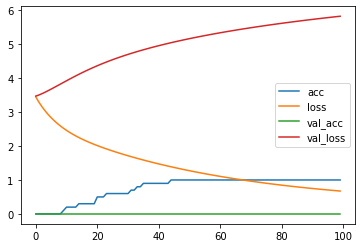

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  D Fh:  0.71 Fha:  0.29
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  7 Fh:  0.55 Fha:  0.35
truth:  4   pred:  I Fh:  0.34 Fha:  0.56
truth:  8   pred:  6 Fh:  0.59 Fha:  0.40
truth:  9   pred:  D Fh:  0.78 Fha:  0.32
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  D Fh:  0.73 Fha:  0.28
truth:  J   pred:  3 Fh:  0.67 Fha:  0.40
acc:  0.0


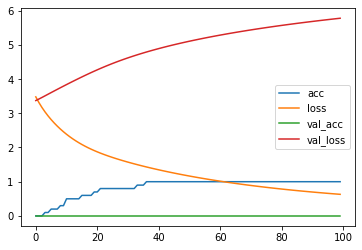

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  D Fh:  0.71 Fha:  0.29
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  D Fh:  0.67 Fha:  0.57
truth:  4   pred:  3 Fh:  0.33 Fha:  0.56
truth:  8   pred:  3 Fh:  0.60 Fha:  0.21
truth:  9   pred:  D Fh:  0.78 Fha:  0.32
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  B Fh:  0.85 Fha:  0.26
truth:  J   pred:  5 Fh:  0.59 Fha:  0.53
acc:  0.0


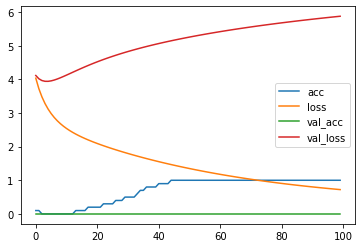

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  D Fh:  0.71 Fha:  0.29
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  3 Fh:  0.53 Fha:  0.48
truth:  4   pred:  A Fh:  0.53 Fha:  0.44
truth:  8   pred:  3 Fh:  0.60 Fha:  0.21
truth:  9   pred:  B Fh:  0.68 Fha:  0.47
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  B Fh:  0.85 Fha:  0.26
truth:  J   pred:  3 Fh:  0.67 Fha:  0.40
acc:  0.0


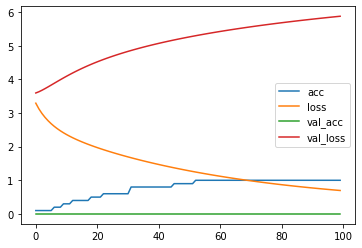

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  D Fh:  0.71 Fha:  0.29
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  7 Fh:  0.55 Fha:  0.35
truth:  4   pred:  A Fh:  0.53 Fha:  0.44
truth:  8   pred:  E Fh:  0.54 Fha:  0.40
truth:  9   pred:  3 Fh:  0.43 Fha:  0.42
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  D Fh:  0.73 Fha:  0.28
truth:  J   pred:  3 Fh:  0.67 Fha:  0.40
acc:  0.0


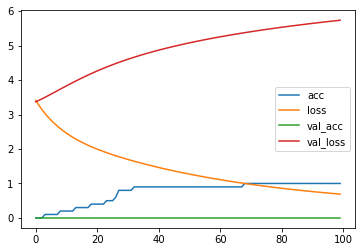

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  6 Fh:  0.59 Fha:  0.30
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  7 Fh:  0.55 Fha:  0.35
truth:  4   pred:  3 Fh:  0.33 Fha:  0.56
truth:  8   pred:  B Fh:  0.76 Fha:  0.42
truth:  9   pred:  D Fh:  0.78 Fha:  0.32
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  B Fh:  0.85 Fha:  0.26
truth:  J   pred:  3 Fh:  0.67 Fha:  0.40
acc:  0.0


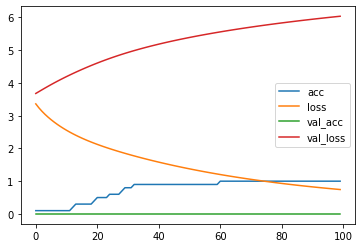

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  D Fh:  0.71 Fha:  0.29
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  3 Fh:  0.53 Fha:  0.48
truth:  4   pred:  C Fh:  0.27 Fha:  0.60
truth:  8   pred:  E Fh:  0.54 Fha:  0.40
truth:  9   pred:  E Fh:  0.39 Fha:  0.56
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  D Fh:  0.73 Fha:  0.28
truth:  J   pred:  3 Fh:  0.67 Fha:  0.40
acc:  0.0


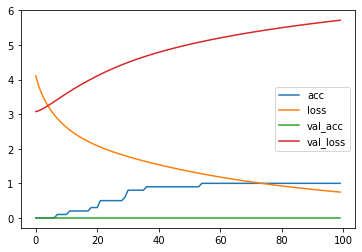

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  3 Fh:  0.39 Fha:  0.40
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  7 Fh:  0.55 Fha:  0.35
truth:  4   pred:  3 Fh:  0.33 Fha:  0.56
truth:  8   pred:  3 Fh:  0.60 Fha:  0.21
truth:  9   pred:  5 Fh:  0.49 Fha:  0.40
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  B Fh:  0.85 Fha:  0.26
truth:  J   pred:  3 Fh:  0.67 Fha:  0.40
acc:  0.0


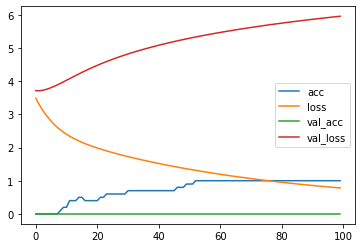

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  D Fh:  0.71 Fha:  0.29
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  7 Fh:  0.55 Fha:  0.35
truth:  4   pred:  A Fh:  0.53 Fha:  0.44
truth:  8   pred:  E Fh:  0.54 Fha:  0.40
truth:  9   pred:  5 Fh:  0.49 Fha:  0.40
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  D Fh:  0.73 Fha:  0.28
truth:  J   pred:  3 Fh:  0.67 Fha:  0.40
acc:  0.0


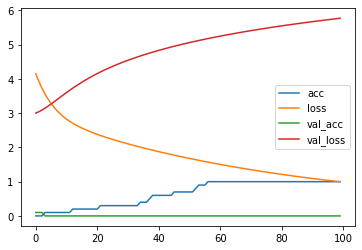

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  B Fh:  0.66 Fha:  0.42
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  7 Fh:  0.55 Fha:  0.35
truth:  4   pred:  I Fh:  0.34 Fha:  0.56
truth:  8   pred:  B Fh:  0.76 Fha:  0.42
truth:  9   pred:  3 Fh:  0.43 Fha:  0.42
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  H   pred:  B Fh:  0.85 Fha:  0.26
truth:  J   pred:  3 Fh:  0.67 Fha:  0.40
acc:  0.0


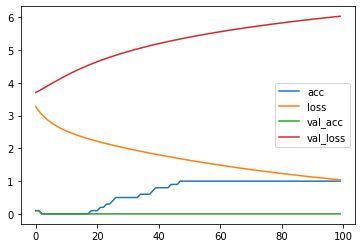

now test the model on the train set
truth:  I   pred:  I Fh:  1.00 Fha:  0.00
truth:  D   pred:  D Fh:  1.00 Fha:  0.00
truth:  E   pred:  E Fh:  1.00 Fha:  0.00
truth:  B   pred:  B Fh:  1.00 Fha:  0.00
truth:  6   pred:  6 Fh:  1.00 Fha:  0.00
truth:  C   pred:  C Fh:  1.00 Fha:  0.00
truth:  A   pred:  A Fh:  1.00 Fha:  0.00
truth:  7   pred:  7 Fh:  1.00 Fha:  0.00
truth:  5   pred:  5 Fh:  1.00 Fha:  0.00
truth:  3   pred:  3 Fh:  1.00 Fha:  0.00
acc:  1.0
now test the model on the test set
truth:  0   pred:  D Fh:  0.71 Fha:  0.29
truth:  1   pred:  I Fh:  0.92 Fha:  0.16
truth:  2   pred:  7 Fh:  0.55 Fha:  0.35
truth:  4   pred:  A Fh:  0.53 Fha:  0.44
truth:  8   pred:  3 Fh:  0.60 Fha:  0.21
truth:  9   pred:  D Fh:  0.78 Fha:  0.32
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  6 Fh:  0.75 Fha:  0.28
truth:  H   pred:  D Fh:  0.73 Fha:  0.28
truth:  J   pred:  7 Fh:  0.35 Fha:  0.63
acc:  0.0
[['1.0' '0.0' '1.0' '0.0' '1.0' '0.0' '1.0' '0.0' '1.0' '0.0' '1.0' '

In [8]:
matrix = []
dev = [0, 0.001, 0.002, 0.003, 0.005,  0.01, 0.02, 0.03, 0.05, 0.1]  
for d in dev:
    samples, fhs, fhas = train_process('Gray', 10, 100, True, 10, d, 0)
    # c = input('continue? [y/ n]')
    # if c == 'y' or c == 'Y':
    #     continue
    # else:
    #     break
    
    matrix.append(fhs)
    matrix.append(fhas)
matrix = np.transpose(np.array(matrix))
print(matrix)
samples = np.array(samples)

header = []
for n in dev:
    header.append((str(n), 'Fh'))
    header.append((str(n), 'Fha'))
print(header)
header = pd.MultiIndex.from_tuples(header)
df = pd.DataFrame(matrix, dtype='float', index=samples, columns=header)
df = df.round(2)
df.to_excel("final.xlsx", index = True, header=True)

print(matrix)
print(samples)

In [9]:
df

0       0.001       0.002       0.003       0.005        0.01        \
     Fh   Fha    Fh   Fha    Fh   Fha    Fh   Fha    Fh   Fha    Fh   Fha   
I  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
D  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
E  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
B  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
6  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
C  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
A  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
7  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
5  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
3  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00   
0  0.71  0.29  0.71  0.29  0.71  0.29  0.71  0.29  0.59  0.30  0.71  0.29   
1  0.92  0.16  0.92  0.16  0.92  0.16  0.92  0.16  0.92  0.16  0.92  0.16   
2  0.55  0.35  0.67  0.57  0.53  0.48  0.55  0.35  0.55  0.35  0.53  0.48   
4  0.34  0.56  0.33  0.56  0.53  0.44  0.53  0.44  0.33  0.56  0.27  0.60   
8  0.59  0.40  0.60  0.21  0.60  0.21  0.54  0.40  0.76  0.42  0.54  0.40   
9  0.78  0.32  0.78  0.32  0.68  0.47  0.43  0.42  0.78  0.32  0.39  0.56   
F  1.00  0.15  1.00  0.15  1.00  0.15  1.00  0.15  1.00  0.15  1.00  0.15   
G  0.73  0.02  0.73  0.02  0.73  0.02  0.73  0.02  0.73  0.02  0.73  0.02   
H  0.73  0.28  0.85  0.26  0.85  0.26  0.73  0.28  0.85  0.26  0.73  0.28   
J  0.67  0.40  0.59  0.53  0.67  0.40  0.67  0.40  0.67  0.40  0.67  0.40   

   0.02        0.03        0.05         0.1        
     Fh   Fha    Fh   Fha    Fh   Fha    Fh   Fha  
I  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
D  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
E  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
B  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
6  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
C  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
A  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
7  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
5  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
3  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  
0  0.39  0.40  0.71  0.29  0.66  0.42  0.71  0.29  
1  0.92  0.16  0.92  0.16  0.92  0.16  0.92  0.16  
2  0.55  0.35  0.55  0.35  0.55  0.35  0.55  0.35  
4  0.33  0.56  0.53  0.44  0.34  0.56  0.53  0.44  
8  0.60  0.21  0.54  0.40  0.76  0.42  0.60  0.21  
9  0.49  0.40  0.49  0.40  0.43  0.42  0.78  0.32  
F  1.00  0.15  1.00  0.15  1.00  0.15  1.00  0.15  
G  0.73  0.02  0.73  0.02  0.73  0.02  0.75  0.28  
H  0.85  0.26  0.73  0.28  0.85  0.26  0.73  0.28  
J  0.67  0.40  0.67  0.40  0.67  0.40  0.35  0.63

In [10]:
test_df = df.iloc[10:]

In [35]:
test_df

0       0.001       0.002       0.003       0.005        0.01        \
     Fh   Fha    Fh   Fha    Fh   Fha    Fh   Fha    Fh   Fha    Fh   Fha   
0  0.71  0.29  0.71  0.29  0.71  0.29  0.71  0.29  0.59  0.30  0.71  0.29   
1  0.92  0.16  0.92  0.16  0.92  0.16  0.92  0.16  0.92  0.16  0.92  0.16   
2  0.55  0.35  0.67  0.57  0.53  0.48  0.55  0.35  0.55  0.35  0.53  0.48   
4  0.34  0.56  0.33  0.56  0.53  0.44  0.53  0.44  0.33  0.56  0.27  0.60   
8  0.59  0.40  0.60  0.21  0.60  0.21  0.54  0.40  0.76  0.42  0.54  0.40   
9  0.78  0.32  0.78  0.32  0.68  0.47  0.43  0.42  0.78  0.32  0.39  0.56   
F  1.00  0.15  1.00  0.15  1.00  0.15  1.00  0.15  1.00  0.15  1.00  0.15   
G  0.73  0.02  0.73  0.02  0.73  0.02  0.73  0.02  0.73  0.02  0.73  0.02   
H  0.73  0.28  0.85  0.26  0.85  0.26  0.73  0.28  0.85  0.26  0.73  0.28   
J  0.67  0.40  0.59  0.53  0.67  0.40  0.67  0.40  0.67  0.40  0.67  0.40   

   0.02        0.03        0.05         0.1        
     Fh   Fha    Fh   Fha    Fh   Fha    Fh   Fha  
0  0.39  0.40  0.71  0.29  0.66  0.42  0.71  0.29  
1  0.92  0.16  0.92  0.16  0.92  0.16  0.92  0.16  
2  0.55  0.35  0.55  0.35  0.55  0.35  0.55  0.35  
4  0.33  0.56  0.53  0.44  0.34  0.56  0.53  0.44  
8  0.60  0.21  0.54  0.40  0.76  0.42  0.60  0.21  
9  0.49  0.40  0.49  0.40  0.43  0.42  0.78  0.32  
F  1.00  0.15  1.00  0.15  1.00  0.15  1.00  0.15  
G  0.73  0.02  0.73  0.02  0.73  0.02  0.75  0.28  
H  0.85  0.26  0.73  0.28  0.85  0.26  0.73  0.28  
J  0.67  0.40  0.67  0.40  0.67  0.40  0.35  0.63

In [41]:
cols = []
for n in dev:
    cols.append((str(n), 'Fh'))
test_Fh = np.transpose(test_df[cols].values)

In [42]:
cols = []
for n in dev:
    cols.append((str(n), 'Fha'))
test_Fha = np.transpose(test_df[cols].values)


In [38]:
import matplotlib.pyplot as plt

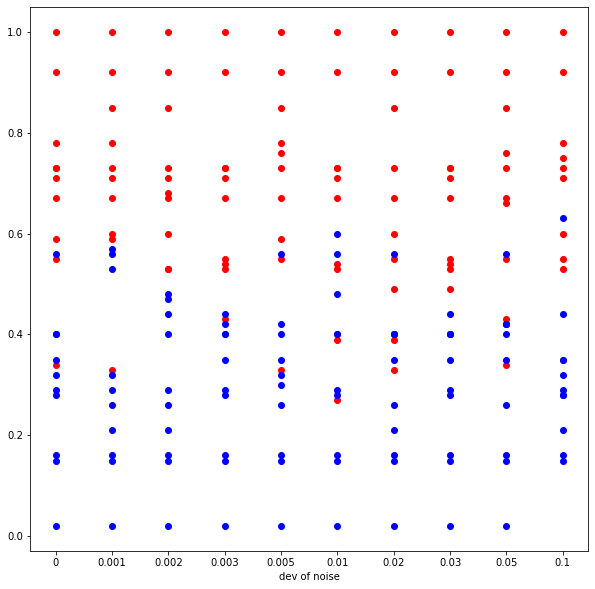

In [49]:

plt.figure(figsize=(10, 10))

for i in range(10):
    fh = test_Fh[i]
    fha = test_Fha[i]
    plt.scatter([i]*10, fh, color='r')
    plt.scatter([i]*10, fha, color='b')

plt.xticks(np.arange(10), dev)
plt.xlabel('dev of noise')
plt.show()